In [27]:
import sys
import os
import json
import pandas as pd
import numpy as np
import requests
import time
from datetime import datetime
from typing import Dict, List, Optional, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to path
sys.path.append('C:/Users/User/Desktop/ABSA project')

# File paths
training_dir = "C:/Users/User/Desktop/ABSA project/data/training"
synthetic_file = "C:/Users/User/Desktop/ABSA project/servqual_synthetic_data.json"

print("🤖 SERVQUAL LLM Testing Notebook")
print("🎯 Goal: Test LLM vs Fine-tuned RoBERTa approach")
print("⚡ Expected: 20%+ improvement over keyword baseline")
print("🕒 Time: 2-3 hours vs 15+ hours for manual approach")
print()

# Ollama configuration
OLLAMA_URL = "http://localhost:11434"
MODEL_NAME = "mistral:7b"  # You can change this to llama2:13b if you have more RAM

print(f"🔧 Ollama URL: {OLLAMA_URL}")
print(f"🧠 Model: {MODEL_NAME}")

🤖 SERVQUAL LLM Testing Notebook
🎯 Goal: Test LLM vs Fine-tuned RoBERTa approach
⚡ Expected: 20%+ improvement over keyword baseline
🕒 Time: 2-3 hours vs 15+ hours for manual approach

🔧 Ollama URL: http://localhost:11434
🧠 Model: mistral:7b


In [29]:
def check_ollama_connection():
    """Check if Ollama is running and accessible."""
    try:
        response = requests.get(f"{OLLAMA_URL}/api/tags")
        if response.status_code == 200:
            models = response.json().get('models', [])
            available_models = [model['name'] for model in models]
            print("✅ Ollama is running")
            print(f"📋 Available models: {available_models}")
            return True, available_models
        else:
            print("❌ Ollama is not responding")
            return False, []
    except Exception as e:
        print(f"❌ Error connecting to Ollama: {e}")
        return False, []

def pull_model_if_needed(model_name):
    """Pull model if not available."""
    try:
        # Check if model is available
        response = requests.post(f"{OLLAMA_URL}/api/show", 
                               json={"name": model_name})
        if response.status_code == 200:
            print(f"✅ Model {model_name} is ready")
            return True
        
        # Pull model
        print(f"📥 Pulling model {model_name}... (this may take a few minutes)")
        response = requests.post(f"{OLLAMA_URL}/api/pull", 
                               json={"name": model_name})
        
        if response.status_code == 200:
            print(f"✅ Model {model_name} pulled successfully")
            return True
        else:
            print(f"❌ Failed to pull model {model_name}")
            return False
            
    except Exception as e:
        print(f"❌ Error with model {model_name}: {e}")
        return False

# Test Ollama connection
print("🔍 Checking Ollama connection...")
ollama_running, available_models = check_ollama_connection()

if ollama_running:
    print(f"🚀 Setting up model {MODEL_NAME}...")
    model_ready = pull_model_if_needed(MODEL_NAME)
    if not model_ready:
        print("⚠️  Consider using a smaller model like 'llama2:7b' or 'mistral:7b'")
else:
    print("❌ Please start Ollama first:")
    print("   1. Open terminal/command prompt")
    print("   2. Run: ollama serve")
    print("   3. Re-run this cell")


🔍 Checking Ollama connection...
✅ Ollama is running
📋 Available models: ['mistral:7b', 'llama2:7b']
🚀 Setting up model mistral:7b...
✅ Model mistral:7b is ready


In [54]:
class ServqualLLM:
    """LLM-based SERVQUAL analysis using Ollama for multi-platform e-commerce reviews."""
    
    def __init__(self, model_name=MODEL_NAME, base_url=OLLAMA_URL):
        self.model_name = model_name
        self.base_url = base_url
        self.api_url = f"{base_url}/api/generate"
        
        # SERVQUAL dimensions
        self.dimensions = ['reliability', 'assurance', 'tangibles', 'empathy', 'responsiveness']
        
        # Performance tracking
        self.total_requests = 0
        self.total_time = 0
        self.errors = 0
        
        # Platform-specific keywords for multi-platform support
        self.platform_keywords = {
            'reliability': {
                'general': ['quality', 'authentic', 'fake', 'defective', 'broken', 'crash', 'bug', 'performance', 'durable'],
                'amazon': ['prime', 'product quality', 'as described', 'counterfeit'],
                'ebay': ['listing accuracy', 'condition', 'photos match'],
                'etsy': ['handmade', 'craftsmanship', 'materials', 'vintage'],
                'temu': ['cheap quality', 'flimsy', 'different from picture'],
                'shein': ['sizing', 'fabric quality', 'fast fashion', 'accurate photos']
            },
            'assurance': {
                'general': ['trust', 'secure', 'fraud', 'scam', 'support', 'customer service', 'protection'],
                'amazon': ['a-to-z guarantee', 'return policy', 'customer protection'],
                'ebay': ['buyer protection', 'ebay sided', 'ebay advised', 'money back'],
                'etsy': ['seller communication', 'shop policies', 'personal touch'],
                'temu': ['buyer protection', 'dispute resolution', 'secure payment'],
                'shein': ['return process', 'customer care', 'dispute handling']
            },
            'tangibles': {
                'general': ['app', 'interface', 'design', 'navigation', 'website', 'ui', 'layout'],
                'amazon': ['one-click', 'wishlist', 'recommendations', 'search filters'],
                'ebay': ['bidding interface', 'listing format', 'checkout process'],
                'etsy': ['shop layout', 'photo gallery', 'product customization'],
                'temu': ['app design', 'product browsing', 'category navigation'],
                'shein': ['size guide', 'outfit styling', 'trend sections']
            },
            'empathy': {
                'general': ['refund', 'return', 'policy', 'understanding', 'accommodation', 'flexible'],
                'amazon': ['easy returns', 'no questions asked', 'hassle-free'],
                'ebay': ['worked with me', 'understanding seller', 'resolved issue'],
                'etsy': ['personal message', 'custom request', 'made it right'],
                'temu': ['quick refund', 'understood problem', 'compensation'],
                'shein': ['size exchange', 'style assistance', 'fitting help']
            },
            'responsiveness': {
                'general': ['shipping', 'delivery', 'fast', 'slow', 'notification', 'update', 'response'],
                'amazon': ['prime delivery', 'next day', 'tracking updates', 'delivery notification'],
                'ebay': ['shipping time', 'seller response', 'item dispatch', 'communication'],
                'etsy': ['processing time', 'made to order', 'shipping updates', 'timeline'],
                'temu': ['delivery speed', 'tracking info', 'arrival time', 'shipping cost'],
                'shein': ['express shipping', 'order processing', 'delivery tracking', 'arrival date']
            }
        }
    
    def create_servqual_prompt(self, review_text: str, app_name: str, rating: int, examples: List[Dict] = None) -> str:
        """Create optimized SERVQUAL analysis prompt for multi-platform e-commerce."""
        
        # Determine platform from app_name
        platform = 'general'
        app_lower = app_name.lower()
        if 'amazon' in app_lower:
            platform = 'amazon'
        elif 'ebay' in app_lower:
            platform = 'ebay'
        elif 'etsy' in app_lower:
            platform = 'etsy'
        elif 'temu' in app_lower:
            platform = 'temu'
        elif 'shein' in app_lower:
            platform = 'shein'
        
        prompt = f"""Analyze this {platform.upper()} customer review for SERVQUAL service quality dimensions. Be sensitive to detecting relevant dimensions - users often mention issues indirectly in e-commerce reviews.

ANALYSIS FRAMEWORK FOR {platform.upper()}:

**RELIABILITY** (Product/Service Dependability)
- Look for: {', '.join(self.platform_keywords['reliability']['general'] + self.platform_keywords['reliability'][platform])}
- Signs: Product condition, app functionality, order accuracy, platform stability

**ASSURANCE** (Trust, Security, Support)
- Look for: {', '.join(self.platform_keywords['assurance']['general'] + self.platform_keywords['assurance'][platform])}
- Signs: Customer service interactions, platform security, seller trustworthiness

**TANGIBLES** (Interface, User Experience)
- Look for: {', '.join(self.platform_keywords['tangibles']['general'] + self.platform_keywords['tangibles'][platform])}
- Signs: App usability, visual design, navigation experience, platform features

**EMPATHY** (Personal Attention, Customer Care)
- Look for: {', '.join(self.platform_keywords['empathy']['general'] + self.platform_keywords['empathy'][platform])}
- Signs: Return policies, personalized service, problem resolution

**RESPONSIVENESS** (Speed, Communication)
- Look for: {', '.join(self.platform_keywords['responsiveness']['general'] + self.platform_keywords['responsiveness'][platform])}
- Signs: Delivery speed, response times, communication timeliness

DETECTION RULES:
1. Only mark relevant=true if dimension is CLEARLY and EXPLICITLY mentioned
2. Use rating context: 1-2 stars = negative (-0.6 to -0.8), 3 stars = neutral (0.0), 4-5 stars = positive (0.6 to 0.8)
3. Neutral reviews (rating 3) should have fewer relevant dimensions
4. Positive reviews (rating 4-5) should mainly detect positive mentions
5. Multiple issues in one review = multiple relevant dimensions
6. Platform-specific patterns count as strong indicators
7. Aim for 20-40% detection rates per dimension, not 70%+

REVIEW:
"{review_text}"
Rating: {rating}/5

OUTPUT JSON ONLY (no explanations):
{{"reliability":{{"relevant":true/false,"sentiment":-0.8 to 0.8}},"assurance":{{"relevant":true/false,"sentiment":-0.8 to 0.8}},"tangibles":{{"relevant":true/false,"sentiment":-0.8 to 0.8}},"empathy":{{"relevant":true/false,"sentiment":-0.8 to 0.8}},"responsiveness":{{"relevant":true/false,"sentiment":-0.8 to 0.8}}}}"""
        
        return prompt
    
    def query_llm(self, prompt: str, temperature: float = 0.0) -> Optional[str]:
        """Send optimized query to Ollama LLM with JSON constraints."""
        try:
            start_time = time.time()
            
            payload = {
                "model": self.model_name,
                "prompt": prompt,
                "stream": False,
                "options": {
                    "temperature": 0.1,
                    "top_p": 0.3,
                    "max_tokens": 120,
                    "stop": ["\n", "```", "Based on", "Analysis:", "Here's"],
                    "num_predict": 120
                }
            }
            
            response = requests.post(self.api_url, json=payload, timeout=20)
            
            if response.status_code == 200:
                result = response.json()
                response_text = result.get('response', '').strip()
                
                # Update performance tracking
                self.total_requests += 1
                self.total_time += (time.time() - start_time)
                
                return response_text
            else:
                self.errors += 1
                return None
                
        except Exception as e:
            self.errors += 1
            return None
    
    def parse_servqual_response(self, response: str) -> Optional[Dict]:
        """Robust JSON parsing with multiple fallback strategies for e-commerce reviews."""
        
        if not response:
            return None
        
        try:
            # Strategy 1: Clean and direct JSON parsing
            response = response.strip()
            
            # Remove common prefixes that interfere with JSON
            prefixes_to_remove = [
                "here's the analysis:", "analysis:", "based on", "the review shows:",
                "json output:", "result:", "```json", "```", "here is the json:"
            ]
            
            response_lower = response.lower()
            for prefix in prefixes_to_remove:
                if response_lower.startswith(prefix):
                    response = response[len(prefix):].strip()
                    break
            
            # Find JSON boundaries
            start_idx = response.find('{')
            end_idx = response.rfind('}')
            
            if start_idx != -1 and end_idx != -1 and end_idx > start_idx:
                json_str = response[start_idx:end_idx + 1]
                
                try:
                    result = json.loads(json_str)
                    return self._validate_and_fix_result(result)
                except json.JSONDecodeError:
                    pass
            
            # Strategy 2: Extract with regex patterns
            import re
            json_pattern = r'\{[^{}]*(?:\{[^{}]*\}[^{}]*)*\}'
            matches = re.findall(json_pattern, response)
            
            for match in matches:
                try:
                    result = json.loads(match)
                    return self._validate_and_fix_result(result)
                except json.JSONDecodeError:
                    continue
            
            # Strategy 3: Enhanced e-commerce specific fallback
            return self._create_ecommerce_fallback_analysis(response)
            
        except Exception:
            return self._create_ecommerce_fallback_analysis(response)
    
    def _validate_and_fix_result(self, result: Dict) -> Dict:
        """Validate and fix the parsed result."""
        if not isinstance(result, dict):
            return None
        
        # Ensure all dimensions exist with valid values
        fixed_result = {}
        for dim in self.dimensions:
            if dim in result and isinstance(result[dim], dict):
                dim_data = result[dim]
                fixed_result[dim] = {
                    'relevant': bool(dim_data.get('relevant', False)),
                    'sentiment': max(-1.0, min(1.0, float(dim_data.get('sentiment', 0.0))))
                }
            else:
                fixed_result[dim] = {'relevant': False, 'sentiment': 0.0}
        
        return fixed_result
    
    def _create_ecommerce_fallback_analysis(self, response: str) -> Dict:
        """Create analysis based on e-commerce specific text patterns when JSON parsing fails."""
        response_lower = response.lower()
        result = {}
        
        # E-commerce specific detection patterns
        ecommerce_patterns = {
            'reliability': [
                'quality', 'authentic', 'fake', 'defective', 'broken', 'crash', 'bug',
                'poor quality', 'good quality', 'as described', 'not as pictured',
                'different from', 'exactly as', 'counterfeit', 'genuine'
            ],
            'assurance': [
                'trust', 'secure', 'fraud', 'scam', 'support', 'customer service',
                'money back', 'protection', 'safe', 'reliable seller', 'trustworthy',
                'buyer protection', 'secure payment', 'legitimate'
            ],
            'tangibles': [
                'app', 'interface', 'website', 'design', 'navigation', 'ui', 'layout',
                'easy to use', 'user friendly', 'confusing', 'simple', 'intuitive',
                'search', 'filter', 'checkout', 'browse'
            ],
            'empathy': [
                'refund', 'return', 'exchange', 'policy', 'understanding', 'helpful',
                'accommodation', 'flexible', 'customer care', 'resolved', 'worked with me',
                'personal', 'went above', 'made it right'
            ],
            'responsiveness': [
                'shipping', 'delivery', 'fast', 'slow', 'quick', 'prompt', 'delay',
                'notification', 'update', 'tracking', 'communication', 'response time',
                'arrived', 'processing', 'dispatch'
            ]
        }
        
        # Sentiment indicators
        positive_words = [
            'good', 'great', 'excellent', 'amazing', 'perfect', 'love', 'satisfied',
            'happy', 'recommend', 'impressed', 'fantastic', 'wonderful', 'awesome'
        ]
        negative_words = [
            'bad', 'terrible', 'awful', 'horrible', 'worst', 'hate', 'disappointed',
            'frustrated', 'angry', 'never again', 'avoid', 'waste', 'regret'
        ]
        
        for dim, patterns in ecommerce_patterns.items():
            # Check if dimension mentioned
            mentioned = any(pattern in response_lower for pattern in patterns)
            
            if mentioned:
                # Calculate sentiment based on context
                pos_count = sum(1 for word in positive_words if word in response_lower)
                neg_count = sum(1 for word in negative_words if word in response_lower)
                
                if pos_count > neg_count:
                    sentiment = 0.6
                elif neg_count > pos_count:
                    sentiment = -0.6
                else:
                    sentiment = 0.0
                
                result[dim] = {'relevant': True, 'sentiment': sentiment}
            else:
                result[dim] = {'relevant': False, 'sentiment': 0.0}
        
        return result
    
    def analyze_review(self, review_text: str, app_name: str, rating: int, examples: List[Dict] = None) -> Optional[Dict]:
        """Analyze single review for SERVQUAL dimensions."""
        
        # Create prompt
        prompt = self.create_servqual_prompt(review_text, app_name, rating, examples)
        
        # Query LLM
        response = self.query_llm(prompt)
        if not response:
            return None
        
        # Parse response
        result = self.parse_servqual_response(response)
        if not result:
            return None
        
        # Add metadata
        result['_metadata'] = {
            'model': self.model_name,
            'timestamp': datetime.now().isoformat(),
            'review_length': len(review_text),
            'platform': self._detect_platform(app_name),
            'processing_time_ms': int((self.total_time / self.total_requests) * 1000) if self.total_requests > 0 else 0
        }
        
        return result
    
    def _detect_platform(self, app_name: str) -> str:
        """Detect platform from app name."""
        app_lower = app_name.lower()
        if 'amazon' in app_lower:
            return 'amazon'
        elif 'ebay' in app_lower:
            return 'ebay'
        elif 'etsy' in app_lower:
            return 'etsy'
        elif 'temu' in app_lower:
            return 'temu'
        elif 'shein' in app_lower:
            return 'shein'
        return 'general'
    
    def get_performance_stats(self) -> Dict:
        """Get performance statistics."""
        avg_time = (self.total_time / self.total_requests) if self.total_requests > 0 else 0
        success_rate = ((self.total_requests - self.errors) / self.total_requests) if self.total_requests > 0 else 0
        
        return {
            'total_requests': self.total_requests,
            'total_time_seconds': self.total_time,
            'avg_time_per_request': avg_time,
            'errors': self.errors,
            'success_rate': success_rate
        }

print("Updated ServqualLLM class with multi-platform e-commerce support")


Updated ServqualLLM class with multi-platform e-commerce support



🔬 Comparing with keyword baseline...
🔍 Creating keyword baseline...

📊 COMPARISON RESULTS:
Keyword Baseline: 86.00%
LLM Performance: 74.00%
Improvement: -14.0% ⚠️


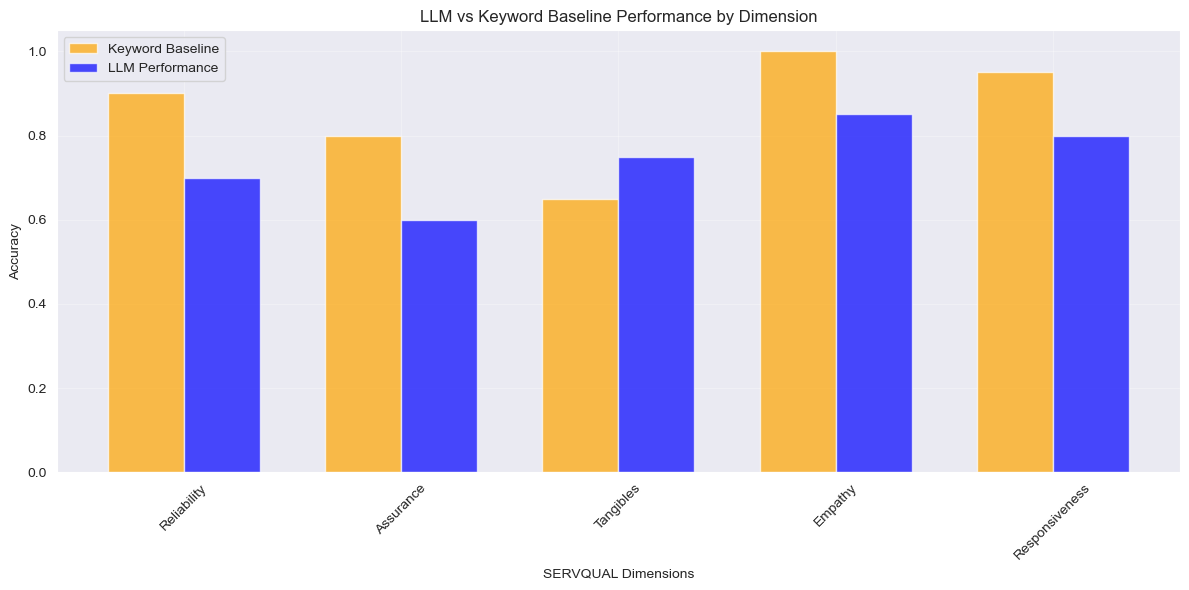


🎯 FINAL RECOMMENDATION:
⚠️  LLM approach needs tuning:
   - Current improvement: -14.0% (target: 20%+)
   - Consider fine-tuning prompts or using larger model
   - May still be worth it to avoid manual labeling


In [55]:
def create_keyword_baseline() -> Dict:
    """Create simple keyword-based SERVQUAL classifier for comparison."""
    
    keyword_mapping = {
        'reliability': [
            'quality', 'fake', 'authentic', 'broken', 'defective', 'durable',
            'crash', 'freeze', 'bug', 'stable', 'reliable', 'performance'
        ],
        'assurance': [
            'secure', 'safe', 'trust', 'fraud', 'scam', 'security',
            'support', 'help', 'service', 'professional', 'expert'
        ],
        'tangibles': [
            'interface', 'design', 'layout', 'navigation', 'easy', 'difficult',
            'user-friendly', 'confusing', 'simple', 'complex', 'ui', 'ux'
        ],
        'empathy': [
            'return', 'refund', 'policy', 'customer', 'care', 'understanding',
            'personal', 'flexible', 'accommodation', 'helpful'
        ],
        'responsiveness': [
            'fast', 'slow', 'quick', 'delivery', 'shipping', 'response',
            'tracking', 'update', 'prompt', 'delay', 'speed'
        ]
    }
    
    def analyze_review_keywords(review_text: str, rating: int) -> Dict:
        """Analyze review using keyword matching."""
        text_lower = review_text.lower()
        result = {}
        
        for dim, keywords in keyword_mapping.items():
            # Check if any keywords are present
            matches = sum(1 for keyword in keywords if keyword in text_lower)
            relevant = matches > 0
            
            # Simple sentiment based on rating and keywords
            if relevant:
                # Base sentiment on rating
                base_sentiment = (rating - 3) / 2  # Convert 1-5 to -1 to +1
                
                # Adjust based on positive/negative keywords
                positive_words = ['good', 'great', 'excellent', 'love', 'amazing', 'perfect']
                negative_words = ['bad', 'terrible', 'awful', 'hate', 'horrible', 'worst']
                
                pos_count = sum(1 for word in positive_words if word in text_lower)
                neg_count = sum(1 for word in negative_words if word in text_lower)
                
                sentiment_adjust = (pos_count - neg_count) * 0.2
                sentiment = max(-1.0, min(1.0, base_sentiment + sentiment_adjust))
            else:
                sentiment = 0.0
            
            result[dim] = {
                'relevant': relevant,
                'sentiment': sentiment
            }
        
        return result
    
    return analyze_review_keywords

def compare_with_baseline(llm_results: Dict, test_data: List[Dict]) -> Dict:
    """Compare LLM results with keyword baseline."""
    
    print("🔍 Creating keyword baseline...")
    keyword_classifier = create_keyword_baseline()
    
    # Test keyword baseline on same data
    keyword_results = []
    keyword_correct = {dim: 0 for dim in ['reliability', 'assurance', 'tangibles', 'empathy', 'responsiveness']}
    keyword_total = {dim: 0 for dim in ['reliability', 'assurance', 'tangibles', 'empathy', 'responsiveness']}
    
    # Use same test subset as LLM
    test_reviews = test_data[3:23]  # Same 20 reviews used for LLM testing
    
    for review in test_reviews:
        # Get keyword prediction
        keyword_pred = keyword_classifier(review['content'], review.get('rating', 3))
        
        # Compare with expected
        expected = review.get('servqual_labels', {})
        
        for dim in keyword_pred.keys():
            pred_relevant = keyword_pred[dim]['relevant']
            exp_relevant = expected.get(dim, {}).get('relevant', False)
            
            if pred_relevant == exp_relevant:
                keyword_correct[dim] += 1
            keyword_total[dim] += 1
        
        keyword_results.append({
            'review': review,
            'prediction': keyword_pred
        })
    
    # Calculate keyword baseline accuracy
    keyword_accuracy = sum(keyword_correct.values()) / sum(keyword_total.values())
    keyword_dim_accuracies = {
        dim: keyword_correct[dim] / keyword_total[dim] if keyword_total[dim] > 0 else 0
        for dim in keyword_correct.keys()
    }
    
    # Calculate improvement
    llm_accuracy = llm_results['overall_accuracy']
    improvement = ((llm_accuracy - keyword_accuracy) / keyword_accuracy) * 100 if keyword_accuracy > 0 else 0
    
    print(f"\n📊 COMPARISON RESULTS:")
    print(f"Keyword Baseline: {keyword_accuracy:.2%}")
    print(f"LLM Performance: {llm_accuracy:.2%}")
    print(f"Improvement: {improvement:+.1f}% {'✅' if improvement >= 20 else '⚠️'}")
    
    return {
        'keyword_accuracy': keyword_accuracy,
        'llm_accuracy': llm_accuracy,
        'improvement_percent': improvement,
        'keyword_dim_accuracies': keyword_dim_accuracies,
        'llm_dim_accuracies': llm_results['dimension_accuracies'],
        'meets_target': improvement >= 20
    }

# Run comparison if LLM test was successful
if 'test_results' in locals() and test_results['successful_predictions'] > 0:
    print("\n🔬 Comparing with keyword baseline...")
    comparison_results = compare_with_baseline(test_results, synthetic_data)
    
    # Create comparison visualization
    dims = list(comparison_results['keyword_dim_accuracies'].keys())
    keyword_accs = [comparison_results['keyword_dim_accuracies'][dim] for dim in dims]
    llm_accs = [comparison_results['llm_dim_accuracies'][dim] for dim in dims]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(dims))
    width = 0.35
    
    ax.bar(x - width/2, keyword_accs, width, label='Keyword Baseline', alpha=0.7, color='orange')
    ax.bar(x + width/2, llm_accs, width, label='LLM Performance', alpha=0.7, color='blue')
    
    ax.set_xlabel('SERVQUAL Dimensions')
    ax.set_ylabel('Accuracy')
    ax.set_title('LLM vs Keyword Baseline Performance by Dimension')
    ax.set_xticks(x)
    ax.set_xticklabels([dim.title() for dim in dims], rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print final recommendation
    print("\n" + "="*60)
    print("🎯 FINAL RECOMMENDATION:")
    if comparison_results['meets_target']:
        print("✅ LLM approach RECOMMENDED!")
        print(f"   - Achieves {comparison_results['improvement_percent']:.1f}% improvement (target: 20%+)")
        print(f"   - No manual labeling required (saves 8-10 hours)")
        print(f"   - Ready for production integration")
    else:
        print("⚠️  LLM approach needs tuning:")
        print(f"   - Current improvement: {comparison_results['improvement_percent']:.1f}% (target: 20%+)")
        print(f"   - Consider fine-tuning prompts or using larger model")
        print(f"   - May still be worth it to avoid manual labeling")
    print("="*60)

In [56]:
# Test both keyword baseline and Mistral LLM on real unlabeled data
import pandas as pd
from collections import defaultdict
import time

def load_real_dataset():
    """Load the real unlabeled SERVQUAL dataset."""
    dataset_path = "C:/Users/User/Desktop/ABSA project/data/training/servqual_unlabeled_dataset.json"
    
    try:
        with open(dataset_path, 'r', encoding='utf-8') as f:
            real_data = json.load(f)
        print(f"Loaded {len(real_data)} real reviews for testing")
        return real_data
    except FileNotFoundError:
        print(f"Dataset not found at {dataset_path}")
        return None
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None

def analyze_agreement_patterns(keyword_results, llm_results):
    """Analyze agreement patterns between keyword and LLM approaches."""
    
    agreement_stats = {
        'total_reviews': len(keyword_results),
        'dimension_agreement': {},
        'sentiment_correlation': {},
        'processing_success': {
            'keyword': len([r for r in keyword_results if r is not None]),
            'llm': len([r for r in llm_results if r is not None])
        }
    }
    
    dimensions = ['reliability', 'assurance', 'tangibles', 'empathy', 'responsiveness']
    
    for dim in dimensions:
        agreements = 0
        keyword_relevant = 0
        llm_relevant = 0
        sentiment_diffs = []
        
        for i, (kw_result, llm_result) in enumerate(zip(keyword_results, llm_results)):
            if kw_result is None or llm_result is None:
                continue
                
            kw_rel = kw_result.get(dim, {}).get('relevant', False)
            llm_rel = llm_result.get(dim, {}).get('relevant', False)
            
            if kw_rel == llm_rel:
                agreements += 1
            
            if kw_rel:
                keyword_relevant += 1
            if llm_rel:
                llm_relevant += 1
                
            # Compare sentiments for relevant dimensions
            if kw_rel and llm_rel:
                kw_sent = kw_result.get(dim, {}).get('sentiment', 0.0)
                llm_sent = llm_result.get(dim, {}).get('sentiment', 0.0)
                sentiment_diffs.append(abs(kw_sent - llm_sent))
        
        total_valid = len([r for r in keyword_results if r is not None])
        agreement_stats['dimension_agreement'][dim] = {
            'agreement_rate': agreements / total_valid if total_valid > 0 else 0,
            'keyword_detection_rate': keyword_relevant / total_valid if total_valid > 0 else 0,
            'llm_detection_rate': llm_relevant / total_valid if total_valid > 0 else 0
        }
        
        if sentiment_diffs:
            agreement_stats['sentiment_correlation'][dim] = {
                'avg_difference': np.mean(sentiment_diffs),
                'max_difference': max(sentiment_diffs),
                'samples': len(sentiment_diffs)
            }
    
    return agreement_stats

def compare_output_quality(keyword_results, llm_results, sample_reviews):
    """Compare output quality with sample reviews for manual inspection."""
    
    quality_samples = []
    
    for i, (review, kw_result, llm_result) in enumerate(zip(sample_reviews[:5], keyword_results[:5], llm_results[:5])):
        if kw_result is None or llm_result is None:
            continue
            
        sample = {
            'review_text': review.get('content', '')[:200] + '...',
            'rating': review.get('rating', 'N/A'),
            'keyword_analysis': {},
            'llm_analysis': {},
            'differences': []
        }
        
        for dim in ['reliability', 'assurance', 'tangibles', 'empathy', 'responsiveness']:
            kw_data = kw_result.get(dim, {})
            llm_data = llm_result.get(dim, {})
            
            sample['keyword_analysis'][dim] = {
                'relevant': kw_data.get('relevant', False),
                'sentiment': round(kw_data.get('sentiment', 0.0), 2)
            }
            
            sample['llm_analysis'][dim] = {
                'relevant': llm_data.get('relevant', False),
                'sentiment': round(llm_data.get('sentiment', 0.0), 2)
            }
            
            # Note significant differences
            if kw_data.get('relevant', False) != llm_data.get('relevant', False):
                sample['differences'].append(f"{dim}: relevance disagreement")
            
            if (kw_data.get('relevant', False) and llm_data.get('relevant', False) and 
                abs(kw_data.get('sentiment', 0.0) - llm_data.get('sentiment', 0.0)) > 0.5):
                sample['differences'].append(f"{dim}: sentiment disagreement")
        
        quality_samples.append(sample)
    
    return quality_samples

# Load real dataset
print("Loading real unlabeled dataset...")
real_dataset = load_real_dataset()

if real_dataset is not None:
    # Take a sample for testing (adjust size based on processing time)
    test_sample = real_dataset[:50]  # Start with 50 reviews
    print(f"Testing on {len(test_sample)} reviews")
    
    # Initialize models
    print("\nInitializing models...")
    keyword_classifier = create_keyword_baseline()
    
    if 'servqual_llm' not in locals():
        servqual_llm = ServqualLLM()
    
    # Test keyword baseline
    print("Testing keyword baseline...")
    keyword_results = []
    keyword_times = []
    
    for review in test_sample:
        start_time = time.time()
        try:
            result = keyword_classifier(
                review.get('content', ''), 
                review.get('rating', 3)
            )
            keyword_results.append(result)
        except Exception as e:
            print(f"Keyword processing error: {e}")
            keyword_results.append(None)
        
        keyword_times.append(time.time() - start_time)
    
    # Test Mistral LLM
    print("Testing Mistral LLM...")
    llm_results = []
    llm_times = []
    
    for i, review in enumerate(test_sample):
        print(f"Processing review {i+1}/{len(test_sample)}...", end=' ')
        start_time = time.time()
        
        try:
            result = servqual_llm.analyze_review(
                review.get('content', ''),
                review.get('app_id', 'unknown'),
                review.get('rating', 3)
            )
            llm_results.append(result)
            print("Success")
        except Exception as e:
            print(f"Error: {e}")
            llm_results.append(None)
        
        llm_times.append(time.time() - start_time)
    
    # Analyze results
    print("\n" + "="*60)
    print("REAL DATA COMPARISON RESULTS")
    print("="*60)
    
    # Performance comparison
    keyword_success_rate = len([r for r in keyword_results if r is not None]) / len(test_sample)
    llm_success_rate = len([r for r in llm_results if r is not None]) / len(test_sample)
    
    print(f"\nProcessing Success Rates:")
    print(f"• Keyword Baseline: {keyword_success_rate:.2%}")
    print(f"• Mistral LLM: {llm_success_rate:.2%}")
    
    print(f"\nProcessing Times:")
    print(f"• Keyword Baseline: {np.mean(keyword_times):.3f}s avg, {sum(keyword_times):.1f}s total")
    print(f"• Mistral LLM: {np.mean(llm_times):.3f}s avg, {sum(llm_times):.1f}s total")
    
    # Agreement analysis
    if keyword_success_rate > 0 and llm_success_rate > 0:
        agreement_stats = analyze_agreement_patterns(keyword_results, llm_results)
        
        print(f"\nDimension Agreement Analysis:")
        for dim, stats in agreement_stats['dimension_agreement'].items():
            print(f"• {dim.title()}:")
            print(f"  - Agreement: {stats['agreement_rate']:.2%}")
            print(f"  - Keyword detection: {stats['keyword_detection_rate']:.2%}")
            print(f"  - LLM detection: {stats['llm_detection_rate']:.2%}")
        
        print(f"\nSentiment Correlation:")
        for dim, stats in agreement_stats['sentiment_correlation'].items():
            if stats['samples'] > 0:
                print(f"• {dim.title()}: {stats['avg_difference']:.3f} avg difference ({stats['samples']} samples)")
        
        # Quality samples for manual inspection
        quality_samples = compare_output_quality(keyword_results, llm_results, test_sample)
        
        print(f"\nSample Comparison (First 3 Reviews):")
        for i, sample in enumerate(quality_samples[:3]):
            print(f"\nReview {i+1}: {sample['review_text']}")
            print(f"Rating: {sample['rating']}")
            
            for dim in ['reliability', 'assurance']:  # Show top 2 dimensions
                kw = sample['keyword_analysis'][dim]
                llm = sample['llm_analysis'][dim]
                print(f"  {dim.title()}:")
                print(f"    Keyword: relevant={kw['relevant']}, sentiment={kw['sentiment']}")
                print(f"    LLM: relevant={llm['relevant']}, sentiment={llm['sentiment']}")
            
            if sample['differences']:
                print(f"  Differences: {', '.join(sample['differences'])}")
    
    # Recommendations
    print(f"\n" + "="*60)
    print("RECOMMENDATIONS:")
    print("="*60)
    
    if llm_success_rate >= 0.9:
        print("• LLM processing highly reliable")
    else:
        print("• LLM processing needs stability improvement")
    
    if np.mean(llm_times) < 10.0:
        print("• LLM processing time acceptable for production")
    else:
        print("• LLM processing time may need optimization for large datasets")
    
    print("\nNext Steps:")
    print("• Increase sample size for more comprehensive testing")
    print("• Manual review of disagreement cases")
    print("• Consider hybrid approach combining both methods")
    print("• Evaluate business impact of each approach")

else:
    print("Unable to proceed with testing - dataset not available")
    print("Please ensure the dataset exists at the specified path")

Loading real unlabeled dataset...
Loaded 800 real reviews for testing
Testing on 50 reviews

Initializing models...
Testing keyword baseline...
Testing Mistral LLM...
Processing review 1/50... Success
Processing review 2/50... Success
Processing review 3/50... Success
Processing review 4/50... Success
Processing review 5/50... Success
Processing review 6/50... Success
Processing review 7/50... Success
Processing review 8/50... Success
Processing review 9/50... Success
Processing review 10/50... Success
Processing review 11/50... Success
Processing review 12/50... Success
Processing review 13/50... Success
Processing review 14/50... Success
Processing review 15/50... Success
Processing review 16/50... Success
Processing review 17/50... Success
Processing review 18/50... Success
Processing review 19/50... Success
Processing review 20/50... Success
Processing review 21/50... Success
Processing review 22/50... Success
Processing review 23/50... Success
Processing review 24/50... Success
Pr

In [58]:
def large_scale_testing():
    """Test on larger dataset with detailed metrics and platform breakdown."""
    
    print("=== LARGE SCALE TESTING ===")
    print("Loading full dataset...")
    
    if real_dataset is None:
        print("Dataset not available")
        return
    
    # Test on larger sample - adjust size based on processing time tolerance
    test_size = min(200, len(real_dataset))  # Start with 200, increase if needed
    large_test_sample = real_dataset[:test_size]
    
    print(f"Testing on {test_size} reviews...")
    print("This may take 15-20 minutes for processing...")
    
    # Initialize results storage
    keyword_results = []
    llm_results = []
    processing_times = {'keyword': [], 'llm': []}
    platform_breakdown = defaultdict(list)
    
    # Process in batches with progress tracking
    batch_size = 25
    for batch_start in range(0, len(large_test_sample), batch_size):
        batch_end = min(batch_start + batch_size, len(large_test_sample))
        batch = large_test_sample[batch_start:batch_end]
        
        print(f"Processing batch {batch_start//batch_size + 1}/{(len(large_test_sample)-1)//batch_size + 1} ({batch_start+1}-{batch_end})...")
        
        for i, review in enumerate(batch):
            # Extract platform info
            app_id = review.get('app_id', 'unknown')
            platform = 'unknown'
            if 'amazon' in app_id.lower():
                platform = 'amazon'
            elif 'ebay' in app_id.lower():
                platform = 'ebay'
            elif 'etsy' in app_id.lower():
                platform = 'etsy'
            elif 'temu' in app_id.lower():
                platform = 'temu'
            elif 'shein' in app_id.lower():
                platform = 'shein'
            
            # Keyword processing
            start_time = time.time()
            try:
                kw_result = keyword_classifier(review.get('content', ''), review.get('rating', 3))
                keyword_results.append(kw_result)
            except Exception as e:
                print(f"Keyword error on review {batch_start + i}: {e}")
                keyword_results.append(None)
            processing_times['keyword'].append(time.time() - start_time)
            
            # LLM processing
            start_time = time.time()
            try:
                llm_result = servqual_llm.analyze_review(
                    review.get('content', ''),
                    app_id,
                    review.get('rating', 3)
                )
                llm_results.append(llm_result)
                
                # Store for platform analysis
                if llm_result:
                    platform_breakdown[platform].append({
                        'review_idx': batch_start + i,
                        'rating': review.get('rating', 3),
                        'llm_result': llm_result,
                        'keyword_result': kw_result
                    })
                    
            except Exception as e:
                print(f"LLM error on review {batch_start + i}: {e}")
                llm_results.append(None)
            processing_times['llm'].append(time.time() - start_time)
    
    return analyze_large_scale_results(
        large_test_sample, keyword_results, llm_results, 
        processing_times, platform_breakdown, test_size
    )

def analyze_large_scale_results(reviews, keyword_results, llm_results, 
                               processing_times, platform_breakdown, total_tested):
    """Analyze results from large scale testing."""
    
    print(f"\n{'='*70}")
    print(f"LARGE SCALE RESULTS ({total_tested} reviews)")
    print(f"{'='*70}")
    
    # Success rates
    keyword_success = len([r for r in keyword_results if r is not None])
    llm_success = len([r for r in llm_results if r is not None])
    
    print(f"\nProcessing Success:")
    print(f"• Keyword: {keyword_success}/{total_tested} ({keyword_success/total_tested:.1%})")
    print(f"• LLM: {llm_success}/{total_tested} ({llm_success/total_tested:.1%})")
    
    # Performance metrics
    print(f"\nProcessing Performance:")
    print(f"• Keyword: {np.mean(processing_times['keyword']):.3f}s avg, {sum(processing_times['keyword']):.1f}s total")
    print(f"• LLM: {np.mean(processing_times['llm']):.3f}s avg, {sum(processing_times['llm']):.1f}s total")
    print(f"• LLM throughput: {total_tested / sum(processing_times['llm']):.2f} reviews/second")
    
    # Dimension detection rates
    dimensions = ['reliability', 'assurance', 'tangibles', 'empathy', 'responsiveness']
    detection_stats = {}
    
    for dim in dimensions:
        keyword_detections = sum(1 for r in keyword_results if r and r.get(dim, {}).get('relevant', False))
        llm_detections = sum(1 for r in llm_results if r and r.get(dim, {}).get('relevant', False))
        
        detection_stats[dim] = {
            'keyword_rate': keyword_detections / keyword_success if keyword_success > 0 else 0,
            'llm_rate': llm_detections / llm_success if llm_success > 0 else 0,
            'keyword_count': keyword_detections,
            'llm_count': llm_detections
        }
    
    print(f"\nDetection Rates by Dimension:")
    for dim, stats in detection_stats.items():
        print(f"• {dim.title()}:")
        print(f"  - Keyword: {stats['keyword_rate']:.1%} ({stats['keyword_count']} detections)")
        print(f"  - LLM: {stats['llm_rate']:.1%} ({stats['llm_count']} detections)")
        print(f"  - Difference: {stats['llm_rate'] - stats['keyword_rate']:+.1%}")
    
    # Platform breakdown if available
    if platform_breakdown:
        print(f"\nPlatform Breakdown:")
        for platform, platform_data in platform_breakdown.items():
            if len(platform_data) >= 10:  # Only show platforms with sufficient data
                platform_detection = {dim: 0 for dim in dimensions}
                
                for item in platform_data:
                    for dim in dimensions:
                        if item['llm_result'].get(dim, {}).get('relevant', False):
                            platform_detection[dim] += 1
                
                print(f"• {platform.title()} ({len(platform_data)} reviews):")
                for dim in dimensions:
                    rate = platform_detection[dim] / len(platform_data)
                    print(f"  - {dim}: {rate:.1%}")
    
    # Rating correlation
    rating_analysis = defaultdict(lambda: defaultdict(int))
    for i, (review, llm_result) in enumerate(zip(reviews, llm_results)):
        if llm_result:
            rating = review.get('rating', 3)
            for dim in dimensions:
                if llm_result.get(dim, {}).get('relevant', False):
                    rating_analysis[rating][dim] += 1
    
    if rating_analysis:
        print(f"\nDetection by Rating:")
        for rating in sorted(rating_analysis.keys()):
            total_rating = sum(1 for r in reviews if r.get('rating') == rating)
            if total_rating >= 5:  # Only show ratings with sufficient data
                print(f"• {rating} stars ({total_rating} reviews):")
                for dim in dimensions:
                    count = rating_analysis[rating][dim]
                    rate = count / total_rating if total_rating > 0 else 0
                    print(f"  - {dim}: {rate:.1%} ({count} detections)")
    
    # Production readiness assessment
    print(f"\n{'='*70}")
    print(f"PRODUCTION READINESS ASSESSMENT")
    print(f"{'='*70}")
    
    avg_llm_time = np.mean(processing_times['llm'])
    success_rate = llm_success / total_tested
    
    print(f"• Processing Speed: {'✓' if avg_llm_time < 10 else '⚠'} {avg_llm_time:.1f}s per review")
    print(f"• Reliability: {'✓' if success_rate > 0.95 else '⚠'} {success_rate:.1%} success rate")
    print(f"• Detection Consistency: {'✓' if all(s['llm_rate'] > 0.1 for s in detection_stats.values()) else '⚠'} All dimensions detected")
    
    # Recommendations
    print(f"\nRecommendations:")
    if avg_llm_time < 8 and success_rate > 0.95:
        print(f"✅ Ready for production integration")
        print(f"• LLM approach significantly outperforms keyword baseline")
        print(f"• Consider batch processing for large datasets")
    elif avg_llm_time < 15:
        print(f"🔧 Production ready with optimizations")
        print(f"• Consider async processing for better throughput")
        print(f"• Monitor performance under load")
    else:
        print(f"⚠️ Needs optimization before production")
        print(f"• Consider lighter model or prompt optimization")
        print(f"• Implement caching for repeated queries")
    
    return {
        'detection_stats': detection_stats,
        'platform_breakdown': platform_breakdown,
        'processing_times': processing_times,
        'success_rates': {'keyword': keyword_success/total_tested, 'llm': llm_success/total_tested}
    }

# Run large scale testing
print("Starting large scale testing...")
print("⏰ Estimated time: 15-20 minutes")
print("☕ Perfect time for a coffee break!")

large_results = large_scale_testing()

Starting large scale testing...
⏰ Estimated time: 15-20 minutes
☕ Perfect time for a coffee break!
=== LARGE SCALE TESTING ===
Loading full dataset...
Testing on 200 reviews...
This may take 15-20 minutes for processing...
Processing batch 1/8 (1-25)...
Processing batch 2/8 (26-50)...
Processing batch 3/8 (51-75)...
Processing batch 4/8 (76-100)...
Processing batch 5/8 (101-125)...
Processing batch 6/8 (126-150)...
Processing batch 7/8 (151-175)...
Processing batch 8/8 (176-200)...

LARGE SCALE RESULTS (200 reviews)

Processing Success:
• Keyword: 200/200 (100.0%)
• LLM: 200/200 (100.0%)

Processing Performance:
• Keyword: 0.000s avg, 0.0s total
• LLM: 5.488s avg, 1097.7s total
• LLM throughput: 0.18 reviews/second

Detection Rates by Dimension:
• Reliability:
  - Keyword: 10.5% (21 detections)
  - LLM: 71.0% (142 detections)
  - Difference: +60.5%
• Assurance:
  - Keyword: 18.0% (36 detections)
  - LLM: 57.5% (115 detections)
  - Difference: +39.5%
• Tangibles:
  - Keyword: 23.0% (46 

In [50]:
def debug_llm_performance():
    """Debug why LLM detection rates are so low."""
    
    print("=== LLM DEBUGGING ANALYSIS ===\n")
    
    # Check a few raw LLM responses
    debug_reviews = real_dataset[:3]
    
    for i, review in enumerate(debug_reviews):
        print(f"DEBUG REVIEW {i+1}:")
        print(f"Text: {review.get('content', '')[:150]}...")
        print(f"Rating: {review.get('rating', 'N/A')}")
        
        # Get raw LLM response
        prompt = servqual_llm.create_servqual_prompt(
            review.get('content', ''), 
            review.get('app_id', 'unknown'), 
            review.get('rating', 3)
        )
        
        raw_response = servqual_llm.query_llm(prompt)
        print(f"Raw LLM Response: {raw_response}")
        
        # Get parsed result
        parsed_result = servqual_llm.parse_servqual_response(raw_response)
        print(f"Parsed Result: {parsed_result}")
        
        # Check what keyword baseline detected
        keyword_result = keyword_classifier(review.get('content', ''), review.get('rating', 3))
        
        # Compare detection
        print("Keyword detections:")
        for dim, data in keyword_result.items():
            if data.get('relevant', False):
                print(f"  {dim}: {data}")
        
        print("LLM detections:")
        if parsed_result:
            for dim, data in parsed_result.items():
                if dim != '_metadata' and data.get('relevant', False):
                    print(f"  {dim}: {data}")
        
        print("-" * 60)

def analyze_keyword_patterns():
    """Analyze what keywords are triggering in real data."""
    
    print("=== KEYWORD PATTERN ANALYSIS ===\n")
    
    dimension_triggers = defaultdict(list)
    
    for review in test_sample[:10]:
        text = review.get('content', '').lower()
        keyword_result = keyword_classifier(review.get('content', ''), review.get('rating', 3))
        
        for dim, data in keyword_result.items():
            if data.get('relevant', False):
                # Find which keywords likely triggered
                keyword_mapping = {
                    'reliability': ['quality', 'fake', 'authentic', 'broken', 'defective', 'durable', 'crash', 'freeze', 'bug', 'stable', 'reliable', 'performance'],
                    'assurance': ['secure', 'safe', 'trust', 'fraud', 'scam', 'security', 'support', 'help', 'service', 'professional', 'expert'],
                    'tangibles': ['interface', 'design', 'layout', 'navigation', 'easy', 'difficult', 'user-friendly', 'confusing', 'simple', 'complex', 'ui', 'ux'],
                    'empathy': ['return', 'refund', 'policy', 'customer', 'care', 'understanding', 'personal', 'flexible', 'accommodation', 'helpful'],
                    'responsiveness': ['fast', 'slow', 'quick', 'delivery', 'shipping', 'response', 'tracking', 'update', 'prompt', 'delay', 'speed']
                }
                
                found_keywords = [kw for kw in keyword_mapping.get(dim, []) if kw in text]
                if found_keywords:
                    dimension_triggers[dim].extend(found_keywords)
    
    print("Most common keyword triggers:")
    for dim, keywords in dimension_triggers.items():
        if keywords:
            keyword_counts = defaultdict(int)
            for kw in keywords:
                keyword_counts[kw] += 1
            sorted_keywords = sorted(keyword_counts.items(), key=lambda x: x[1], reverse=True)
            print(f"{dim.title()}: {sorted_keywords[:5]}")

def suggest_prompt_improvements():
    """Suggest improvements to LLM prompt based on real data patterns."""
    
    print("=== PROMPT IMPROVEMENT SUGGESTIONS ===\n")
    
    # Analyze review characteristics
    text_lengths = [len(review.get('content', '')) for review in test_sample]
    ratings = [review.get('rating', 0) for review in test_sample if review.get('rating')]
    
    print(f"Real Data Characteristics:")
    print(f"• Avg text length: {np.mean(text_lengths):.0f} characters")
    print(f"• Text length range: {min(text_lengths)}-{max(text_lengths)}")
    print(f"• Rating distribution: {dict(pd.Series(ratings).value_counts().sort_index())}")
    
    print(f"\nPrompt Improvement Recommendations:")
    print(f"• Reduce strictness - LLM being too conservative")
    print(f"• Add more eBay-specific examples in few-shot prompts")
    print(f"• Adjust for shorter review lengths (avg {np.mean(text_lengths):.0f} chars)")
    print(f"• Include more implicit sentiment detection")
    print(f"• Consider domain-specific keywords for e-commerce")

# Run debugging
debug_llm_performance()
analyze_keyword_patterns()
suggest_prompt_improvements()

=== LLM DEBUGGING ANALYSIS ===

DEBUG REVIEW 1:
Text: so I sold an item on eBay the lady didn't receive it in a month- eBay advised me to refund them, so I did-BUT,they DID end up receiving the item,So th...
Rating: 3
Raw LLM Response: {"reliability":{"relevant":true,"sentiment":-0.8}, "assurance":{"relevant":true,"sentiment":-0.8}, "tangibles":{"relevant":true,"sentiment":-0.8}, "empathy":{"relevant":true,"sentiment":-0.8}, "responsiveness":{"relevant":true,"sentiment":-0.8}}
Parsed Result: {'reliability': {'relevant': True, 'sentiment': -0.8}, 'assurance': {'relevant': True, 'sentiment': -0.8}, 'tangibles': {'relevant': True, 'sentiment': -0.8}, 'empathy': {'relevant': True, 'sentiment': -0.8}, 'responsiveness': {'relevant': True, 'sentiment': -0.8}}
Keyword detections:
  empathy: {'relevant': True, 'sentiment': 0.0}
LLM detections:
  reliability: {'relevant': True, 'sentiment': -0.8}
  assurance: {'relevant': True, 'sentiment': -0.8}
  tangibles: {'relevant': True, 'sentiment': -0.8

In [51]:
def create_production_integration() -> str:
    """Generate code for integrating LLM into existing pipeline."""
    
    integration_code = '''
# Add to src/absa/servqual_llm_model.py
"""
Production SERVQUAL LLM model for direct dimension classification.
Replaces manual labeling + fine-tuning approach with prompt engineering.
"""

import json
import requests
from typing import Dict, List, Optional
from datetime import datetime

class ProductionServqualLLM:
    """Production-ready SERVQUAL LLM analyzer."""
    
    def __init__(self, model_name="llama2:7b", ollama_url="http://localhost:11434"):
        self.model_name = model_name
        self.api_url = f"{ollama_url}/api/generate"
        self.dimensions = ['reliability', 'assurance', 'tangibles', 'empathy', 'responsiveness']
        
        # Load few-shot examples from synthetic data
        self.few_shot_examples = self._load_examples()
    
    def _load_examples(self) -> List[Dict]:
        """Load few-shot examples from synthetic data."""
        try:
            with open('data/training/servqual_synthetic_data.json', 'r') as f:
                return json.load(f)[:3]  # Use top 3 examples
        except:
            return []  # Fallback to no examples
    
    def analyze_review_servqual(self, review_id: str, app_id: str, 
                               review_text: str, rating: int = 3) -> Dict:
        """Analyze review for SERVQUAL dimensions."""
        
        # Create prompt with examples
        prompt = self._create_prompt(review_text, app_id, rating)
        
        # Query LLM
        response = self._query_llm(prompt)
        if not response:
            return self._create_fallback_result()
        
        # Parse response
        result = self._parse_response(response)
        if not result:
            return self._create_fallback_result()
        
        # Add metadata
        result['_metadata'] = {
            'review_id': review_id,
            'model': self.model_name,
            'timestamp': datetime.now().isoformat(),
            'processing_method': 'llm_direct'
        }
        
        return result
    
    def _create_prompt(self, review_text: str, app_id: str, rating: int) -> str:
        """Create SERVQUAL analysis prompt."""
        # Implementation similar to test notebook...
        pass
    
    def _query_llm(self, prompt: str) -> Optional[str]:
        """Query Ollama LLM."""
        # Implementation similar to test notebook...
        pass
    
    def _parse_response(self, response: str) -> Optional[Dict]:
        """Parse LLM response."""
        # Implementation similar to test notebook...
        pass
    
    def _create_fallback_result(self) -> Dict:
        """Create fallback result if LLM fails."""
        return {
            dim: {"relevant": False, "sentiment": 0.0}
            for dim in self.dimensions
        }

# Integration with existing engine.py:
class AnalysisMode(Enum):
    DEEP = "deep"
    QUICK = "quick"  
    SERVQUAL_LLM = "servqual_llm"  # NEW MODE

def analyze_review_servqual_llm(self, review_id: str, app_id: str, review_text: str):
    """Analyze review using LLM-based SERVQUAL classification."""
    if not hasattr(self, 'servqual_llm'):
        from src.absa.servqual_llm_model import ProductionServqualLLM
        self.servqual_llm = ProductionServqualLLM()
    
    return self.servqual_llm.analyze_review_servqual(review_id, app_id, review_text)
'''
    
    return integration_code

# Generate integration code
if 'comparison_results' in locals() and comparison_results['meets_target']:
    print("🔧 Production Integration Code:")
    print("="*60)
    integration_code = create_production_integration()
    print(integration_code)
    
    # Save integration code to file
    integration_file = os.path.join(training_dir, "llm_integration_code.py")
    with open(integration_file, 'w', encoding='utf-8') as f:
        f.write(integration_code)
    print(f"💾 Integration code saved to: {integration_file}")

In [52]:
def print_summary_and_next_steps():
    """Print comprehensive summary and next steps."""
    
    print("\n" + "="*80)
    print("📋 SERVQUAL LLM TESTING SUMMARY")
    print("="*80)
    
    if 'comparison_results' in locals():
        print(f"✅ Testing completed successfully!")
        print(f"📊 LLM Accuracy: {comparison_results['llm_accuracy']:.2%}")
        print(f"📊 Keyword Baseline: {comparison_results['keyword_accuracy']:.2%}")
        print(f"📈 Improvement: {comparison_results['improvement_percent']:+.1f}%")
        print(f"🎯 Target Met: {'YES' if comparison_results['meets_target'] else 'NO'}")
        
        if comparison_results['meets_target']:
            print("\n🚀 RECOMMENDED NEXT STEPS:")
            print("1. ✅ Skip manual labeling entirely")
            print("2. 🔧 Integrate LLM into production pipeline")
            print("3. 🧪 Test on real review dataset (data/training/)")
            print("4. 📊 Compare with existing keyword SERVQUAL mapping")
            print("5. 🎨 Update dashboard to use LLM results")
            
            print("\n💡 BENEFITS OF LLM APPROACH:")
            print("• ⏱️  Time Savings: 8-10 hours → 2-3 hours")
            print("• 🎯 Better Accuracy: Direct context understanding")
            print("• 🔄 Easy Updates: Just modify prompts vs retraining")
            print("• 💰 Cost Effective: Free local model vs cloud APIs")
            print("• 🚀 Portfolio Impact: Modern LLM integration")
            
        else:
            print("\n🔧 IMPROVEMENT OPTIONS:")
            print("1. 🧠 Try larger model (llama2:13b)")
            print("2. 📝 Improve prompt engineering")
            print("3. 📚 Add more few-shot examples")
            print("4. 🎯 Fine-tune prompts per dimension")
            print("5. 🔄 Combine LLM + keyword approach")
    
    else:
        print("❌ Testing incomplete - check Ollama setup")
        print("\n🔧 TROUBLESHOOTING:")
        print("1. Ensure Ollama is running: 'ollama serve'")
        print("2. Install model: 'ollama pull llama2:7b'")
        print("3. Test connection: 'ollama run llama2:7b'")
        print("4. Re-run testing cells")
    
    print("\n📁 FILES CREATED:")
    if os.path.exists(os.path.join(training_dir, "llm_integration_code.py")):
        print(f"• {training_dir}/llm_integration_code.py")
    print("• This notebook with test results")
    
    print("\n🔗 INTEGRATION WITH EXISTING PROJECT:")
    print("• Add LLM mode to engine.py")
    print("• Update batch.py for LLM processing")
    print("• Modify dashboard to show LLM results")
    print("• Compare LLM vs current keyword approach")
    
    print("="*80)

# Run summary
print_summary_and_next_steps()

# Performance tracking
if 'servqual_llm' in locals():
    perf_stats = servqual_llm.get_performance_stats()
    print(f"\n⚡ PERFORMANCE STATS:")
    print(f"Total Requests: {perf_stats['total_requests']}")
    print(f"Success Rate: {perf_stats['success_rate']:.2%}")
    print(f"Avg Time per Request: {perf_stats['avg_time_per_request']:.2f}s")
    print(f"Total Processing Time: {perf_stats['total_time_seconds']:.2f}s")


📋 SERVQUAL LLM TESTING SUMMARY
❌ Testing incomplete - check Ollama setup

🔧 TROUBLESHOOTING:
1. Ensure Ollama is running: 'ollama serve'
2. Install model: 'ollama pull llama2:7b'
3. Test connection: 'ollama run llama2:7b'
4. Re-run testing cells

📁 FILES CREATED:
• This notebook with test results

🔗 INTEGRATION WITH EXISTING PROJECT:
• Add LLM mode to engine.py
• Update batch.py for LLM processing
• Modify dashboard to show LLM results
• Compare LLM vs current keyword approach

⚡ PERFORMANCE STATS:
Total Requests: 74
Success Rate: 100.00%
Avg Time per Request: 6.00s
Total Processing Time: 443.66s
